# Визуализация истории-1

In [1]:
from alex.database import Database # вспомогательный класс для подключения к базе и работе с sql
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from decimal import Decimal
%matplotlib inline

In [2]:
import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('csv')

DataTransformerRegistry.enable('csv')

In [3]:
db = Database() # подключение к базе данных с учётными данными для Alex

In [63]:
def optimize_df(df):
    # оптимизация размера датафрейма - преобразование в категории того, чего надо 
    # и присвоение типа Decimal фин.показателям
    try:
        for col in df.columns:
            if col in ('id'):
                df[col] = df[col].astype(Decimal)
            if col in ('exchange', 'pair', 'bid_ask', 'side'):
                df[col] = df[col].astype('category')
            if col in ('price', 'amount', 'volume'):
                df[col] = df[col].astype(Decimal)
        return df
    except Exception as e:
        print(e)

## Загрузка истории

In [64]:
exchange = "binance"
pair = "ETH/USDT"
lag_seconds = 7200

sql = f"select * from tvf_get_history_seconds_ago({lag_seconds}) order by dt, id"
history = optimize_df(db.query(sql))

In [65]:
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32996 entries, 0 to 32995
Data columns (total 8 columns):
id            32965 non-null object
dt            32996 non-null datetime64[ns]
id_ex_pair    32996 non-null int64
exchange      32996 non-null category
pair          32996 non-null category
price         32996 non-null object
amount        32996 non-null object
side          32996 non-null category
dtypes: category(3), datetime64[ns](1), int64(1), object(3)
memory usage: 1.4+ MB


In [66]:
history.sort_values('id', inplace=True)
history.index = pd.to_datetime(history.dt)

In [67]:
history.head()

,id,dt,id_ex_pair,exchange,pair,price,amount,side
dt,,,,,,,,
2018-09-25 22:00:46,1.03961e+07,2018-09-25 22:00:46,351,poloniex,ETH/USDT,208.533,0.12598,buy
2018-09-25 22:02:18,1.03961e+07,2018-09-25 22:02:18,351,poloniex,ETH/USDT,208.01,0.0721579,sell
2018-09-25 22:02:44,1.03961e+07,2018-09-25 22:02:44,351,poloniex,ETH/USDT,208.02,0.507799,sell
2018-09-25 22:02:44,1.03961e+07,2018-09-25 22:02:44,351,poloniex,ETH/USDT,208.02,24.2836,sell
2018-09-25 22:04:01,1.03961e+07,2018-09-25 22:04:01,351,poloniex,ETH/USDT,208.018,0.135822,sell


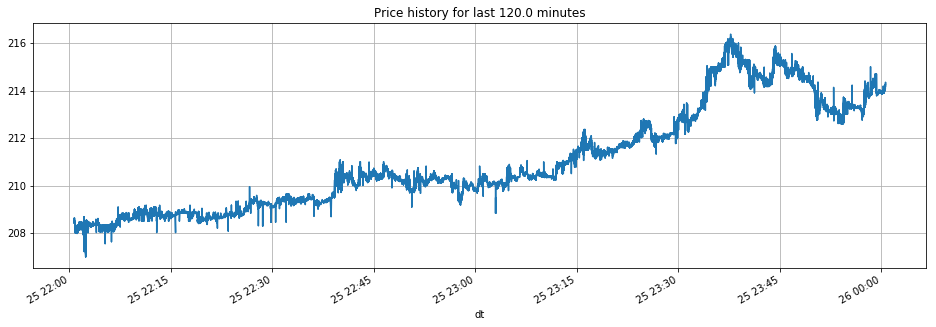

In [68]:
history['price'].plot(grid=True)
plt.title(f"Price history for last {lag_seconds/60} minutes")
plt.rcParams['figure.figsize'] = [16, 5]
plt.show()

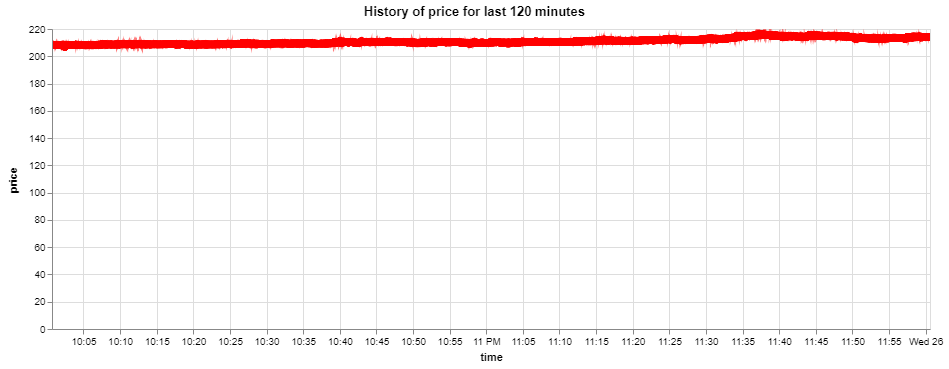

In [69]:
base = alt.Chart(history).encode(
    alt.X("dt:T", title="time"),
    alt.Y("price:Q")
).properties(
    title=f"History of price for last {int(lag_seconds/60)} minutes",
    width=878
)
chart = base.mark_point(
            color="red",
            opacity=0.5,
        ) + \
        base.mark_line(
            color="red",
            opacity=0.5
        )
chart.interactive()

In [16]:
period = 21600 # seconds
interval = 5 # minutes
sql = f"select * from ohlc({period}, {interval}) where id_ex_pair=19 order by id_ex_pair, [date] desc"
df = optimize_df(db.query(sql))
df.index = pd.to_datetime(df.date)
#ohlc.set_index(ohlc.dt, inplace=True)
# del df['dt']
df.head()

,date,id_ex_pair,exchange,pair,open,high,low,close,volume,trades
date,,,,,,,,,,
2018-09-25 14:25:00,2018-09-25 14:25:00,19,binance,ETH/USDT,210.160004,210.380005,209.869995,209.990005,1085.43,284
2018-09-25 14:20:01,2018-09-25 14:20:01,19,binance,ETH/USDT,209.639999,211.000000,209.619995,210.130005,2857.34,661
2018-09-25 14:15:00,2018-09-25 14:15:00,19,binance,ETH/USDT,209.309998,210.000000,209.220001,209.639999,2522.88,502
2018-09-25 14:10:00,2018-09-25 14:10:00,19,binance,ETH/USDT,210.020004,210.259995,209.039993,209.240005,2759.42,856
2018-09-25 14:05:01,2018-09-25 14:05:01,19,binance,ETH/USDT,211.039993,211.110001,209.669998,210.190002,2858.12,742


In [24]:
exchange = df.iloc[0,:]['exchange']
pair = df.iloc[0,:]['pair']

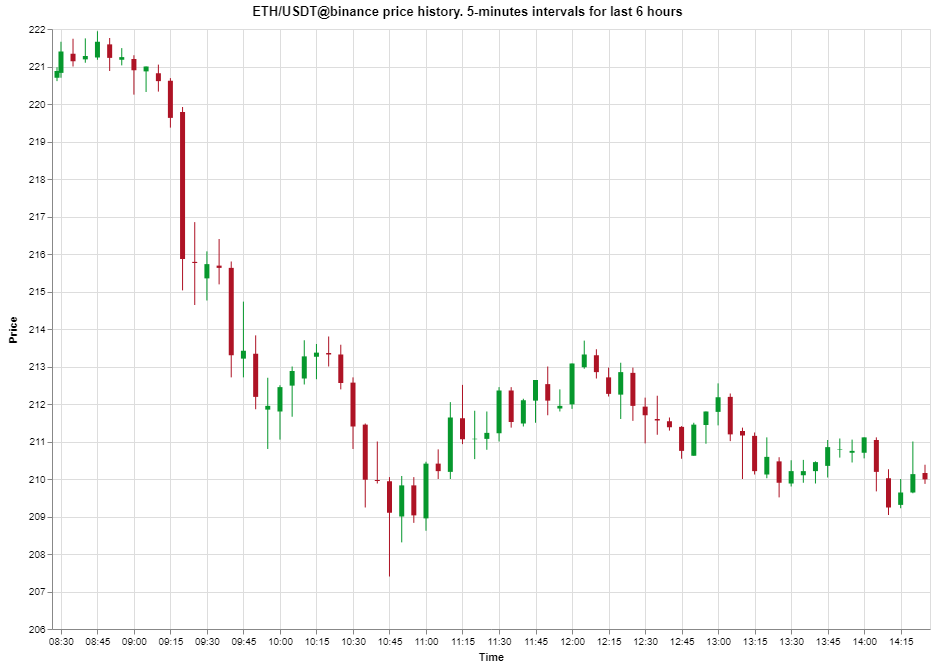

In [28]:
open_close_color = alt.condition("datum.open < datum.close",
                                 alt.value("#06982d"),
                                 alt.value("#ae1325"))

high_low = alt.Chart(df).mark_rule().encode(
    alt.X(
        'date:T',
        axis=alt.Axis(format='%H:%M', title='Time')
    ),
    alt.Y(
        'low',
        scale=alt.Scale(zero=False),
        axis=alt.Axis(title='Price')
    ),
    alt.Y2('high'),
    color=open_close_color
)
open_close = alt.Chart(df).mark_bar().encode(
    x='date:T',
    y='open',
    y2='close',
    color=open_close_color
)

chart = high_low + open_close
chart.properties(
    title=f"{pair}@{exchange} price history. {interval}-minutes intervals for last {int(period/60/60)} hours",
    width=878,
    height=600
).interactive()

In [39]:
history

,id,id_ex_pair,exchange,pair,price,amount,side
dt,,,,,,,
2018-09-25 12:24:21,37176050,19,binance,ETH/USDT,212.62,1.038,buy
2018-09-25 12:24:21,37176051,19,binance,ETH/USDT,212.62,0.3299,buy
2018-09-25 12:24:21,37176052,19,binance,ETH/USDT,212.63,1.03878,buy
2018-09-25 12:24:23,37176053,19,binance,ETH/USDT,212.63,0.46994,sell
2018-09-25 12:24:24,37176054,19,binance,ETH/USDT,212.64,0.46994,sell
2018-09-25 12:24:24,37176055,19,binance,ETH/USDT,212.63,35,sell
2018-09-25 12:24:24,37176056,19,binance,ETH/USDT,212.61,0.81439,sell
2018-09-25 12:24:24,37176057,19,binance,ETH/USDT,212.61,0.18561,sell
2018-09-25 12:24:24,37176058,19,binance,ETH/USDT,212.62,0.47001,sell
